In [183]:
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import numpy as np
import os
import sys

In [200]:
joint_dict = {'Nose': 0, 'LEye': 1, 'REye': 2, 'LEar': 3, 'REar': 4, 'LShoulder': 5, 'RShoulder': 6, 'LElbow': 7, 'RElbow': 8, 'LWrist': 9, 'RWrist': 10, 'LHip': 11, 'RHip': 12, 'LKnee': 13, 'RKnee': 14, 'LAnkle': 15, 'RAnkle': 16}
cam_dict = {'C001': 'Intel RealSense D415', 'C002': 'Intel RealSense D415', 'C003': 'Intel RealSense D415', 'C004': ' Intel RealSense D455'}
action_dict = {'STOP': 0, 'GO RIGHT': 1, 'GO LEFT': 2, 'COME HERE': 3, 'FOLLOW ME': 4, 'GET ATTENTION': 5, 'BE QUIET': 6, 'STANDING STILL': 7, 'BEING SEATED': 8, 'WALKING TOWARDS': 9, 'WALKING AWAY': 10, 'TALKING ON PHONE': 11}

def show_skeleton(skeleton, reverse=True, as_video=False, save_with_name="", frame=0):
  ###
  # Skeleton: (frame_count, 17, num of dimentions, e.g. 2)
  # reverse: The plot is upside down, set it to False when the original plot is needed
  # as_video: Generates and displays a video from the skeleton sequences
  # save_with_name: Saves a video from the skeleton sequences with the given file name,
  #                 ignored if as_video is set to False
  # frame: the frame number to plot the skeleton from,
  #         should not exceed the total frame count of the sequence
  ###

  frame_count = skeleton.shape[0] # Total frame count
  if frame_count <= frame:
    print("Frame count exceeded!")
    return

  # Create a new figure
  fig = plt.figure()
  ax = fig.add_subplot(111)

  # Define the connections between keypoints (assuming a specific order)
  connections = [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8),
                (7, 9), (8, 10), (5, 11), (6, 12), (5, 6), (11, 12), (11, 13),
                (12, 14), (13, 15), (14, 16)]

  def update_frame(updated_frame):
    ax.cla()
    # Example skeleton data
    skeleton_data = np.array(skeleton)[updated_frame]  # List of skeleton data, each element is a matrix of shape (Frame count, 17, 2) representing the 2D locations

    if reverse:
      skeleton_data[:, 1] = skeleton_data[:, 1] * -1

    # Plot keypoints
    ax.scatter(skeleton_data[:, 0], skeleton_data[:, 1], marker='o')

    # Plot connections
    for connection in connections:
        ax.plot([skeleton_data[connection[0], 0], skeleton_data[connection[1], 0]],
                [skeleton_data[connection[0], 1], skeleton_data[connection[1], 1]])

    # Add keypoint labels
    for j, point in enumerate(skeleton_data):
        ax.text(point[0], point[1], str(j), fontsize=8)
    # Set plot limits and labels
    ax.set_xlim([-1, 1])  # Specify the width of your image
    ax.set_ylim([-1, 1])  # Specify the height of your image
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

  if as_video:
    rc('animation', html='jshtml')
    animation = FuncAnimation(fig, update_frame, frames=frame_count, interval=200)
    if save_with_name != "":
      animation.save(save_with_name + ".mp4")
    return animation
  else:
    update_frame(frame)
    plt.show()

def filter_data(data, lab):
  # Get indexes of discarded samples (only some labels are used)
  discarded = []
  for idx in range(len(lab)):
    if lab[idx].upper() not in list(action_dict.keys()):
      discarded.append(idx)
  # Remove discarded elements from the data
  print("Before --- Data length:", len(data), "-", "Label length:", len(lab))
  data_filtered = []
  labels_filtered = []
  for idx in range(len(lab)):
      # checking if element not present in index list
      if idx not in discarded:
          data_filtered.append(data[idx])
          labels_filtered.append(lab[idx])
  print("After --- Data length:", len(data_filtered), "-", "Label length:", len(labels_filtered))
  return data_filtered, labels_filtered

def get_min_max_frame_length(data_filtered):
  # Detect minimum and maximum frame length
  min_val = data_filtered[0].shape[0]
  max_val = data_filtered[0].shape[0]
  min_val_idx = 0
  for i in range(len(data_filtered)):
      if data[i].shape[0] < min_val:
          min_val = data_filtered[i].shape[0]
          min_val_idx = i
      if data[i].shape[0] > max_val:
          max_val = data_filtered[i].shape[0]
          max_val_idx = i
  print('Min:', min_val, 'at', min_val_idx, '-', 'Max:', max_val, 'at', max_val_idx)
  return min_val, min_val_idx, max_val, max_val_idx

def get_false_preds(y_truth, preds):
  # Pick false classifications
  false = []
  for idx in range(len(preds)):
    if y_truth[idx] != preds[idx]:
      false.append(preds[idx])
  return false

def one_hot_to_category_idx(y_test):
  # Convert one hot encoded vectors into category indexes
  y_truth = []

  for y in y_test:
      category = [cat for cat in range(y.shape[0]) if y[cat] == 1][0]
      y_truth.append(category)
  return y_truth

def plotConfusionMatrix(y_truth, preds):
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  confusion_matrix = confusion_matrix(y_truth, preds)
  disp = ConfusionMatrixDisplay(confusion_matrix)
  disp.plot()

In [ ]:
drive.mount('/content/drive')

In [ ]:
!wget https://nextcloud.sdu.dk/index.php/s/AiyBziPXNGFmTTw/download/skeletons.zip
!wget https://tubcloud.tu-berlin.de/s/tfi7AJoEPR312gyJ3/download/HRI_data.zip
!unzip skeletons.zip
!unzip HRI_data.zip

In [ ]:
sys.path.append(os.path.abspath("content/data_parser.py"))

In [186]:
import data_parser
data, lab = data_parser.get_data_HRI('/content/drive/MyDrive/CommandRecognition/skeletons')

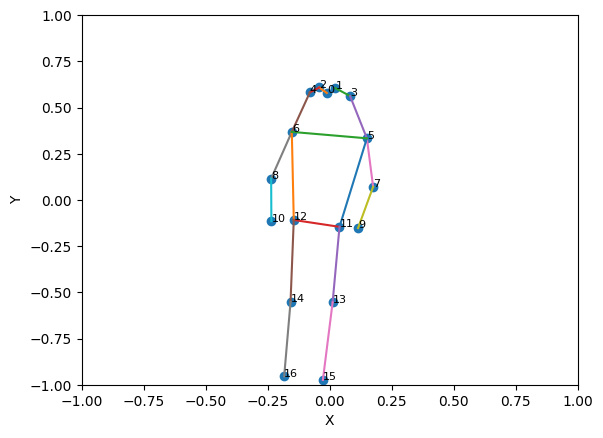

In [187]:
anim = show_skeleton(data[0], reverse=True, as_video=False, frame=0)
anim

In [188]:
data_filtered, labels_filtered = filter_data(data, lab)
get_min_max_frame_length(data_filtered)

Before --- Data length: 13380 - Label length: 13380
After --- Data length: 8004 - Label length: 8004
Min: 69 at 7095 - Max: 86 at 5909


(69, 7095, 86, 5909)

In [193]:
from tensorflow.keras.utils import to_categorical, split_dataset, pad_sequences
from sklearn.model_selection import train_test_split

# Get label values
labels_as_num = []
for lab_idx in range(len(labels_filtered)):
  label_key = labels_filtered[lab_idx].upper()
  labels_as_num.append(action_dict[label_key])

# One Hot Encoding of labels
categorical_labels = to_categorical(labels_as_num)

# Pad the sequences to a fixed length
padded_train_data = pad_sequences(data_filtered, padding='post', dtype='float32')

# Reshape the input data to (samples, frames, features as 17x3)
reshaped_train_data = np.reshape(padded_train_data[:,:,:,:3], (padded_train_data.shape[0], padded_train_data.shape[1], -1))

# Split train and test and shuffle
X_train, X_test, y_train, y_test = train_test_split(reshaped_train_data, categorical_labels, train_size=0.8, test_size=0.20, random_state=42)

In [194]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

to_train=False

if to_train:
  model = keras.Sequential()
  model.add(layers.Masking(mask_value=0, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(layers.LSTM(64))
  model.add(layers.Dense(128))
  model.add(layers.Dense(64))
  model.add(layers.Dense(12, activation='softmax'))
  model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics="categorical_accuracy")
  model.summary()
else:
  model = keras.models.load_model("/content/drive/MyDrive/CommandRecognition/trained_100_bSize32_test20_test_acc89")

In [ ]:
if to_train:
  model.fit(X_train, y_train, batch_size=32, epochs=100)

In [195]:
model.evaluate(X_test, y_test, batch_size=32)

51/51 [==============================] - 2s 19ms/step - loss: 14.3177 - categorical_accuracy: 0.0125


[14.317727088928223, 0.012492191977798939]

In [ ]:
model.save('/content/drive/MyDrive/CommandRecognition/trained_100_bSize32_test20_test_acc89_wMask')

In [196]:
preds = np.argmax(model.predict(X_test), axis=1)

51/51 [==============================] - 2s 17ms/step


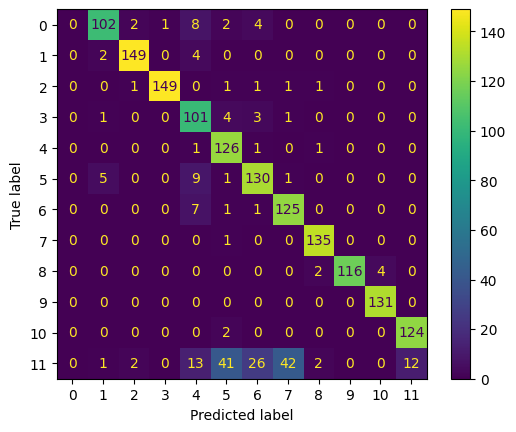

In [201]:
y_truth = one_hot_to_category_idx(y_test)
false_preds = get_false_preds(y_truth, preds)
plotConfusionMatrix(y_truth, preds)